# Describing model predictions when have categorical features, using SHAP interactions: Using Titanic survival as an example use case.

## Plain English summary

When fitting a machine learning model to data to make a prediction, it is now possible, with the use of the SHAP library, to allocate contributions of the prediction onto the feature values, so you can understand what the model used to obtain it's prediction.

SHAP values are calculated for a fitted model. These are in the same units as the model output (for XGBoost these are in log odds - they are additive).

SHAP values provide a base value which is the same values for all of the instances. This values represents the models best guess for any instance without any extra knowledge about the instance. The "expected value". In addition to this, a SHAP value is calculated per feature. These are instance dependent as they also capture the interactions between paris of feature values. This means that the SHAP feature values are in turn made up of a main effect (what is due to being that feature value, standalone) and also the pair-wise interactions with the other features.

This notebook extends notebook 90 by exploring how to interpret SHAP interactions when there are categorical features in the dataset. To fit a XGBoost model to a dataset with categorical features, we need to represent them as one-hot encoded features. This results in a separate feature for each level of the categorical variable. This is all well and good for fitting the model, but one feature is now represented by a SHAP value per level. How do you interpret all of these SHAP values and SHAP interaction values? 

Here we fit an XGBoost model to the Titanic dataset, to predict whether a passenger survives from the values of four features, three which are continuous (gender, age, ticket class) and one categorical feature with three levels represented as one-hot features(port embarked: Southampton,  Cherbourg, Queenstown). We calculate the SHAP interactions of this fitted model and show the most useful way (that we have found) to present all of these values in order to gain the most insight into how the model is working - using a grid of SHAP dependency plots.

This notebook is based on the blog https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a and https://towardsdatascience.com/shap-for-categorical-features-7c63e6a554ea

## Model and data

XGBoost models were trained on all of the data (not split into training and test set). The six features in the model are:

* male: genger of the passenger (0 = female, 1 = male)
* Pclass: Class of the ticket (1 = first, 2 = second, 3 = third class)
* Age: Age of passenger, in years
* Embarked_S: Passenger embarked at Southampton
* Embarked_C: Passenger embarked at Cherbourg
* Embarked_Q: Passenger embarked at Queenstown

And one target feature:
* Survived: Did the passenger survive the sinking of the Titanic (0 = not survive, 1 = survive)

## Aims

* Fit XGBoost model using feature data to predict whether passenger survived
* Calculate the SHAP values and SHAP interaction values
* Understand the SHAP values and SHAP interaction values when have a one-hot encoded feature
* Find the best way to display these values in order to gain the most insight into the relationships that the model is using

## Observations

* SHAP interactions are awesome! 
* Viewing them as a grid of SHAP dependency plots clearly shows the overall relationships that the model uses to derive it's predictions for the whole dataset.

## Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from xgboost import XGBClassifier

# Import shap for shapley values
import shap # `pip install shap` if neeed

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

# So can take deep copy
import copy

from scipy import stats

# do we need these?
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score,confusion_matrix
import xgboost as xgb

/home/kerry/anaconda3/envs/samuel2/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/kerry/anaconda3/envs/samuel2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and process data

#### Download data

First we will download pre-processed data, and saves it to a subfolder (from where this code is run).
If data has already been downloaded that cell may be skipped.

Code that was used to pre-process the data ready for machine learning may be found at:
https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/01_preprocessing.ipynb

In [2]:
download_required = False

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

#### Load data
Read in the dataset (already contains the one-hot encoding of the features)

In [3]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)

#### Restrict data

Restrict to 4 features and target feature.

Use 3 continuous variables, and 1 categorical variable (with 3 levels) represented in it's one-hot encoded form.
And a binary target variable.

In [4]:
ohe_feature_names = ['male', 'Pclass', 'Age', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Survived']
data = data[ohe_feature_names]

## Divide into X (features) and y (labels)

We will separate out our features (the data we use to make a prediction) from our label (what we are truing to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (survived or not) `y`.

In [5]:
# Use `survived` field as y, and drop for X
y = data['Survived'] # y = 'survived' column from 'data'
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column

Average survival (this is the expected outcome of each passenger, without knowing anything about the passenger)

In [6]:
print (f'Average survival: {round(y.mean(),2)}')

Average survival: 0.38


## Fit XGBoost model

We will fit a model to all of the data (rather than train/test splits used to assess accuracy).

In [7]:
#model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)
model = XGBClassifier(random_state=42)
model.fit(X, y)

[16:22:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Get the predictions for each patient (in terms of the classification, and the probability of being in either class)

In [8]:
y_pred = model.predict(X)
y_proba = model.predict_proba(X)

Calculate the models accuracy

In [9]:
accuracy = np.mean(y == y_pred)
print(f'Model accuracy: {accuracy:0.3f}')

Model accuracy: 0.889


In [10]:
print(confusion_matrix(y, y_pred))
accuracy_score(y, y_pred)

[[520  29]
 [ 70 272]]


0.8888888888888888

## Get SHAP values

TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees. Using this we can calculate the SHAP values.

# SHAP for catgeorical features 

We've seen above that the categorical feature represented as a one-hot encoded feature have a SHAP value for each of the one-hot encoded features.

Looking at them in isolation gives us the contribution of each in respect to the feature value.

As SHAP values are additive, we have the option of joining them together (summing each of the one-hot features) to give us the overall contribution of the whole feature, to be described as "the contribution of passenger embarking from Southampton, and not at the others".

In [11]:
# Set up the method to estimate SHAP values for tree models and ensembles of
# trees
explainer = shap.TreeExplainer(model)

# Get SHAP values
shap_values = explainer(X)

# To recap

We can fit a model to data that contains a categorical feature represented as one-hot encded features, and calculate their SHAP values and choose whether to represent them as their individual one-hot encoded components ("what each value contributes to the prediction"), or their combined effect ("what having this value, and not the others, contributes to the prediction").

Let's take a simple example and represent each of these options as an equation.

We have a continous feature "1" and a categorical feature "2" with two levels: A and B. For this example, let's assume that the instance is A, not B, for feature 2.

Here we will use this nomenclature:

P = Prediction\
B = Base value\
Sx = SHAP value for feature x (where x can be the continuous feature (such as 1), or one-hot encded categorical feature (such as 2A and 2B))

Option 1: Keeping the one-hot encoded features separate, we have:\

P = B + S1 + S2A + S2B

Option 2: We can sum the associated one-hot encoded features, and treat them as a single value (the combination of S2A and S2B gives the overall contribution for feature 2):\

P = B + S1 + S2A+B

where S2A+B = (S2A + S2B)

Describe S1 as “contribution from feature 1 on prediction”.
Describe S2A as “contribution from attending A on prediction”.
Describe S2B as “contribution from not attending B on prediction”.
Describe S2A+B as “contribution from attending A, and not the other, on prediction”.

# Next

We want to extend our understanding of the model and not just look at the SHAP values, but also the SHAP interactions. This involves representing a each SHAP value as it's main effect and pair-wise interaction with each of the other features.

Here we will use this nomenclature:

SMx = SHAP main effect for feature x
Sx,y = SHAP interaction for feature pairing x,y

For a model with two features, where feature 2 has two levels, the SHAP value for feature 1 will be:

S1 = SM1 + S1,2A + S1,2B

Now lets look at the equation if we represent the SHAP values as their components: main effect + feature interactions. 

For this example assume the instance is A, not B, for feature 2.

Let’s start with keeping the one-hot encoded features separate.

P = B + SM1 + S1,2A + S1,2B + SM2A + S2A, 1 + S2A,2B + SM2B + S2B,1 + S2B,2A

Describe SM1 as “contribution of feature 1 on prediction, without other feature interactions”.
Describe S1,2A as “contribution of the interaction between feature 1 and feature 2 attending A on prediction”. (Note this value will be identical to S2A,1)
Describe S1,2B as “contribution of the interaction between feature 1 and feature 2 not attending B on prediction”. (Note this value will be identical to S2B,1)
Describe SM2A as “contribution from attending A on prediction, without other feature interactions”.
Describe S2A,2B as “contribution of the interaction between feature 2 attending A and not attending B on prediction”. (Note this value will be identical to S2B,2A).

For our Titanic case, we have three continuous features, and one categorical feature with three levels.
This will result in the prediction being the sum of six SHAP values: S1 + S2 + S3 + S4A + S4B + S4C, where they can be represented as their SHAP interactions:\
S1 = SM1 + S1,2 + S1,3 + S1,4A + S1,4B + S1,4C\
S2 = SM2 + S2,1 + S2,3 + S2,4A + S2,4B + S2,4C\
S3 = SM3 + S3,1 + S3,2 + S3,4A + S3,4B + S3,4C\
S4A = SM4A + S4A,1 + S4A,2 + S4A,3 + S4A,4B + S4A,4C\
S4B = SM4B + S4B,1 + S4B,2 + S4B,3 + S4B,4A + S4B,4C\
S4C = SM4C + S4C,1 + S4C,2 + S4C,3 + S4C,4A + S4C,4B

When we view the SHAP interaction matrix, the positions will represent:

SM1   - S1,2  - S1,3  - S1,4A  - S1,4B  - S1,4C\
S2,1  - SM2   - S2,3  - S2,4A  - S2,4B  - S2,4C\
S3,1  - S3,2  - SM3   - S3,4A  - S3,4B  - S3,4C\
S4A,1 - S4A,2 - S4A,3 - SM4A   - S4A,4B - S4A,4C\
S4B,1 - S4B,2 - S4B,3 - S4B,4A - SM4B   - S4B,4C\
S4C,1 - S4C,2 - S4C,3 - S4C,4A - S4C,4B - SM4C


We will use this to create the necessary code and to explore how to represent all of this information.

## Get SHAP interaction values

Use the TreeExplainer to also calculate the SHAP main effect and SHAP interaction values (the sum of which give the SHAP values for each feature).

In [23]:
# Get SHAP interaction values
shap_interaction = explainer.shap_interaction_values(X)

SHAP interaction values have a matrix of values (per pair of features) per instance.

In this case, each of the 891 instances has a 6x6 matrix of SHAP interaction values (with the SHAP main effect on the diagonal positions).

In [24]:
shap_interaction.shape

(891, 6, 6)

Show SHAP interation matrix (with main effect on the diagonal positions) for the first instance. Notice how the SHAP interation for pairs of features are symmetrical across the diagonal.

In [25]:
shap_interaction[0]

array([[-1.0891066e+00,  2.2040239e-01, -3.0365595e-01, -4.3315761e-02,
         7.3947432e-03,  6.7694254e-02],
       [ 2.2040248e-01, -8.1175739e-01,  1.9097516e-01, -5.6460202e-03,
        -5.9260172e-04, -1.0859532e-02],
       [-3.0365592e-01,  1.9097508e-01, -3.9585939e-01, -1.7480180e-01,
        -7.4080881e-03, -3.6095325e-03],
       [-4.3315709e-02, -5.6460798e-03, -1.7480171e-01, -4.0876184e-02,
        -1.6274861e-03, -3.5410374e-03],
       [ 7.3946714e-03, -5.9260428e-04, -7.4080825e-03, -1.6274899e-03,
         7.4156616e-03,  0.0000000e+00],
       [ 6.7694128e-02, -1.0859579e-02, -3.6095679e-03, -3.5410374e-03,
         0.0000000e+00, -1.1464213e-01]], dtype=float32)

### SHAP interaction matrix: show mean absolute values

Here we see the absolute mean of the SHAP interaction values for all of the instances.\ The values on the diagonal show the main effect for the feature, and the other values show the SHAP interaction for pairs of features (these are symetrical across the diagonal)

In [26]:
mean_abs_interactions = pd.DataFrame(
    np.abs(shap_interaction).mean(axis=(0)),
    index=X.columns, columns=X.columns)

mean_abs_interactions.round(2)

,male,Pclass,Age,Embarked_C,Embarked_Q,Embarked_S
male,1.42,0.34,0.24,0.04,0.02,0.08
Pclass,0.34,0.85,0.28,0.02,0.01,0.04
Age,0.24,0.28,0.67,0.08,0.03,0.10
Embarked_C,0.04,0.02,0.08,0.10,0.00,0.00
Embarked_Q,0.02,0.01,0.03,0.00,0.03,0.00
Embarked_S,0.08,0.04,0.10,0.00,0.00,0.10


The proportion of SHAP that is from the interactions: calculated from the absolute mean

Looking at all of the instances together, what proportion of the SHAP value comes from the SHAP interations

In [27]:
total_shap = mean_abs_interactions.sum().sum()

interaction_shap = (mean_abs_interactions.sum().sum() - 
                    np.diagonal(mean_abs_interactions).sum().sum())

print(f'The proportion of the SHAP values coming from the interactions are: '
      f'{interaction_shap/total_shap:0.3f}')
print(f'The proportion of the SHAP values coming from the main effects are: '
      f'{1 - (interaction_shap/total_shap):0.3f}')

The proportion of the SHAP values coming from the interactions are: 0.446
The proportion of the SHAP values coming from the main effects are: 0.554


The proportion of SHAP that is from the interactions: calculated per instance from the absolute values

Looking at each instances, what proportion of the SHAP value comes from the SHAP interations. Show the range of proportions (one per instance) as a histogram.

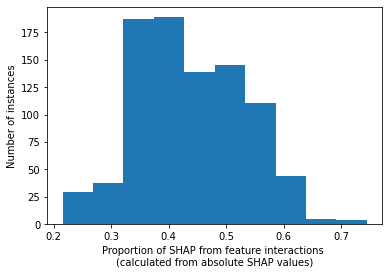

In [28]:
# sum the absolute interaction matrix per instance
abs_total_shap_per_instance = np.abs(shap_interaction).sum(axis=(1,2))

# Initialise list
proportion_interaction = []

# For each instance
for i in range(abs_total_shap_per_instance.shape[0]):
    # sum the absolute feature interactions (off diagonal positions)
    abs_interaction = (abs_total_shap_per_instance[i] - 
                       np.diagonal(np.abs(shap_interaction[i])).sum())
    # calculate the proportion from feature interactions
    proportion_interaction.append(
                abs_interaction / abs_total_shap_per_instance[i])

# plot as histogram
plt.hist(proportion_interaction);
plt.xlabel("Proportion of SHAP from feature interactions \n"
           "(calculated from absolute SHAP values)")
plt.ylabel("Number of instances")
plt.show()

### SHAP interaction matrix: represented as histograms

Show the distribution of all of the instance values for each SHAP interation and SHAP main effect.

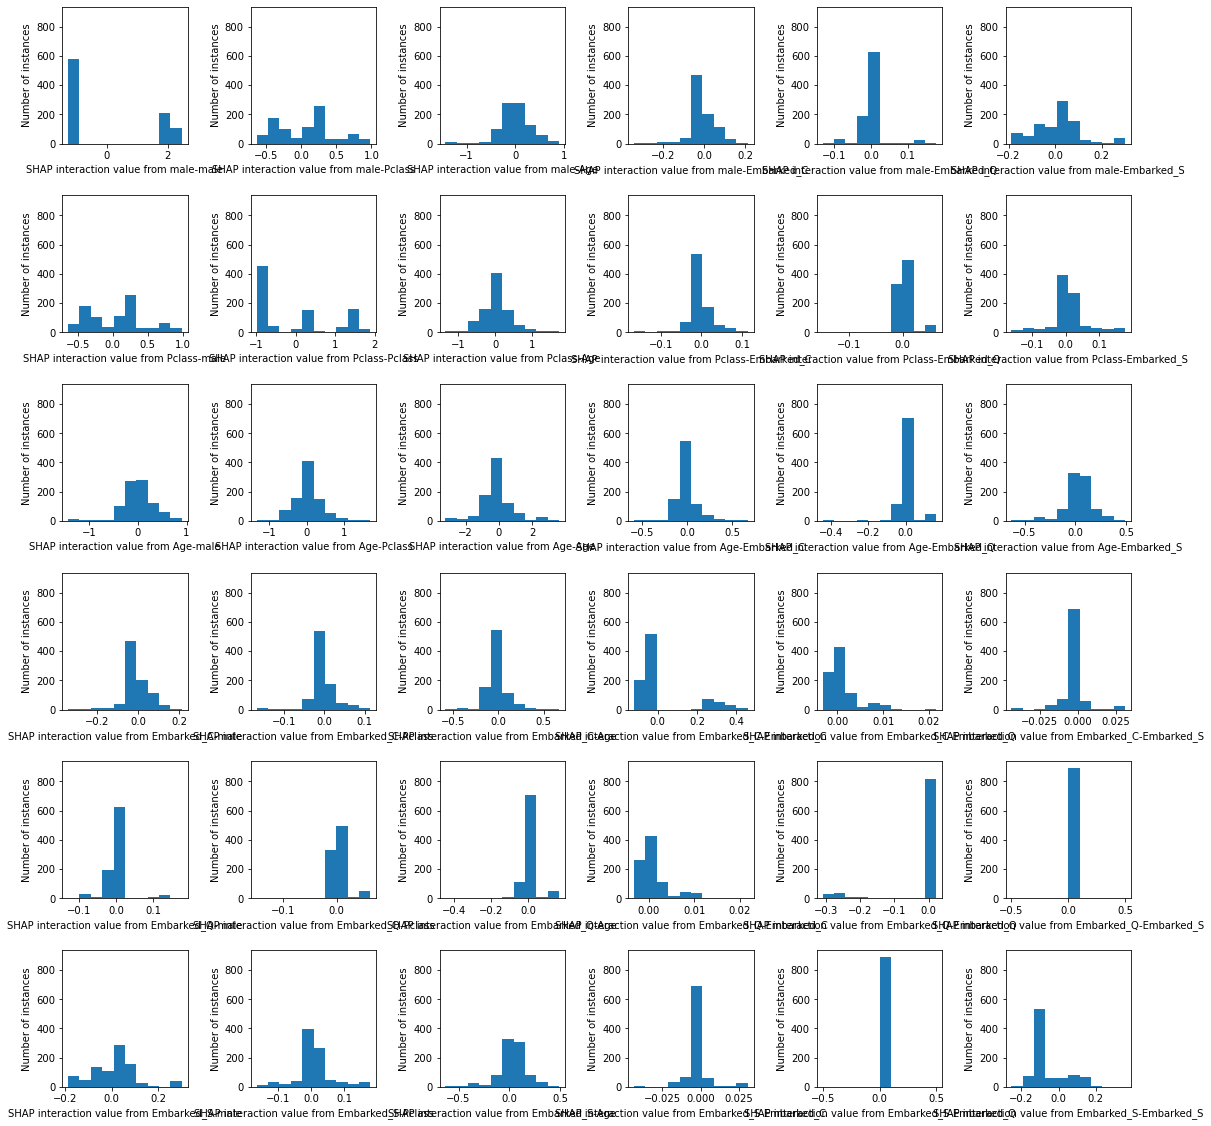

In [29]:
features = X.columns
n_features = len(features)

# Find the largest value used for the y axis in all of the histograms in the 
#   subplots (use this to set the max for each subplot)
y_max = -1
fig, axes = plt.subplots(1)
for i in range(n_features):
    for j in range(n_features):    
        axes.hist(shap_interaction[:,i,j])
        ylims = axes.get_ylim()
        # Store if greater than found so far
        y_max = max(y_max, ylims[1])
# Don't display plot
plt.close(fig)

# Setup figure with subplots
fig, axes = plt.subplots(
    nrows=len(features), 
    ncols=len(features))
axes = axes.ravel()        

count = 0
for i in range(n_features):
    for j in range(n_features):    
        ax=axes[count]
        ax.hist(shap_interaction[:,i,j])
        ax.set_xlabel(f"SHAP interaction value from {features[i]}-{features[j]}")
        ax.set_ylabel("Number of instances")
        ax.set_ylim(0, y_max)
        count += 1
        
fig.set_figheight(16)
fig.set_figwidth(16)
plt.tight_layout(pad=2)
#fig.subplots_adjust(hspace=0.4, wspace=0.9)
plt.show()

### Show a worked example for the first instance

Start with the feature values, and then show the SHAP values and how they can be represented as main effect and interactions. Also show that by summing them along with the base value gives the model output.

In [30]:
instance = 0
target_category = ["not survive", "survive"]
# Show data for first example
print ('Showing a worked example for the first instance')
print ('==============================================')
print ()
print ('------------------')
print ('Feature data values')
print ('------------------')
print (X.iloc[instance])

# Model output
prob_survive = y_proba[instance][1]
logodds_survive = np.log(prob_survive/(1 -prob_survive))
print ()
print ('-------------------')
print ('Model output values')
print ('-------------------')
print (f'1. Model probability [not survive, survive]: ' +
       f'{np.round(y_proba[instance],3)}')
##print ('------------')
#print (np.round(y_proba[instance],3))
print (f'\n2. Model log odds survive: {round(logodds_survive,3)}')
#print ('------------')
#print(round(logodds_survive,3))
cat = np.int(y_pred[instance])
print (f'\n3. Model classification: {cat} ({target_category[cat]})')
##print ('------------')
#print (y_pred[instance])

print ()
print ('-----------------')
print ('SHAP base value (log odds)')
print ('---------------')
print (shap_values.base_values[instance])
print ('\nNote: This is the same value for all of the instances. This is the ' +
       'models best guess without additional knowledge about the instance')
 
#example_shap = pd.DataFrame(shap_values.values[instance],columns=X.columns)
print ()
print ('-----------------')
print ('SHAP values (log odds)')
print ('------------')
# print (example_shap)
for i in range(len(shap_values.values[instance])):
    v = shap_values.values[instance][i]
    print (f'{X.columns.values[i]}: {v:0.3f}')
v = shap_values.values[instance].sum()
print (f'Total = {v:0.3f}')

print ('\nNote: These are patient dependent')
#print ()
#print ('-----------------')
#print ('Sum of SHAP values')
#print ('------------')
#print (shap_values.values[instance].sum())

print (f'\nThe "Model log odds survive" value ({logodds_survive:0.3g}, ' +
       f'see above) is calculated by adding up the SHAP base value ' +
       f'({shap_values.base_values[instance]:0.3f}, see above) with ' +
       f'all of the SHAP values for each feature ' +
       f'({shap_values.values[instance].sum():0.3f}, see above)')
print (f'{shap_values.base_values[instance]:0.3f} + ' +
       f'{shap_values.values[instance].sum():0.3f} = ' +
       f'{logodds_survive:0.3f}')

# SHAP interaction values for first employee
example_interaction = pd.DataFrame(shap_interaction[instance],
                                   index=X.columns,columns=X.columns)
row_total = example_interaction.sum(axis=0)
column_total = example_interaction.sum(axis=1)
total = example_interaction.sum().sum()
example_interaction['Total'] = row_total
example_interaction.loc['Total'] = column_total
example_interaction.loc['Total']['Total'] = total

print ()
print ('-----------------')
print ('SHAP interactions (log odds)')
print ('-----------------')
print ('\n* Each instance has a different SHAP value for the features. This ' +
       'is because the model is also capturing the interaction between pairs ' +
       'of features, and how that contributes to the features SHAP value.')
print ('* Each feature has a SHAP main effect (on the diagonal) and a SHAP ' +
       'interaction effect with each of the other features (off the diagonal)')
print ('* SHAP interaction is split symetrically, eg. age-male is the same ' +
       'as male-age.')
print ('* For each feature, the sum of the SHAP main effect and all of its ' +
       'SHAP interaction values = SHAP value for the feature (shown in ' +
       '"Total", and can be compared to the SHAP values above)')
print ()
print (example_interaction)

print ('------------------')
print ('\nThe model prediction for each instance can be arrived at by ' +
       'starting at the SHAP base value, and adding on the SHAP values from ' +
       'all of the the main effects (one per feature) and from all of the ' +
       'SHAP interactions (two per pair of features).')

Showing a worked example for the first instance

------------------
Feature data values
------------------
male           1.0
Pclass         3.0
Age           22.0
Embarked_C     0.0
Embarked_Q     0.0
Embarked_S     1.0
Name: 0, dtype: float64

-------------------
Model output values
-------------------
1. Model probability [not survive, survive]: [0.96 0.04]

2. Model log odds survive: -3.17

3. Model classification: 0 (not survive)

-----------------
SHAP base value (log odds)
---------------
-0.58842766

Note: This is the same value for all of the instances. This is the models best guess without additional knowledge about the instance

-----------------
SHAP values (log odds)
------------
male: -1.141
Pclass: -0.417
Age: -0.694
Embarked_C: -0.270
Embarked_Q: 0.005
Embarked_S: -0.065
Total = -2.582

Note: These are patient dependent

The "Model log odds survive" value (-3.17, see above) is calculated by adding up the SHAP base value (-0.588, see above) with all of the SHAP values fo

## Show the sum of all of the SHAP interactions adds up to the log odds of predicted P for all instances

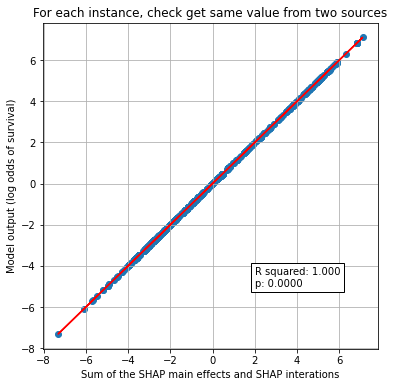

In [31]:
# Model output: probability survive
prob_survive = y_proba[:,1]
# Calculate log odds
logodds_survive = np.log(prob_survive/(1 -prob_survive))

# sum each matrix to get a value per instance
total_shap_per_instance = shap_values.base_values + shap_interaction.sum(axis=(1,2))

x = total_shap_per_instance
y = logodds_survive

# Fit a regression line to the points
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(x, y)
r_square = r_value ** 2
y_pred = intercept + (x * slope)


# Create scatter plot with regression line
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(x, y)
plt.plot (x, y_pred, color = 'red')
text = f'R squared: {r_square:.3f}\np: {p_value:0.4f}'
ax1.text(2, -5, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
ax1.set_xlabel("Sum of the SHAP main effects and SHAP interations")
ax1.set_ylabel("Model output (log odds of survival)")
plt.title("For each instance, check get same value from two sources")
plt.grid()
#plt.savefig('./output/scatter_plot_hosp_shap_vs_10k_thrombolysis.jpg', dpi=300,
#    bbox_inches='tight', pad_inches=0.2)

plt.show()

# Histogram of total SHAP

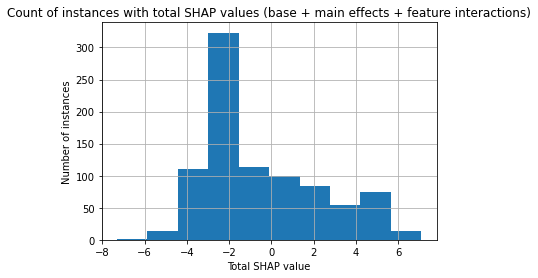

In [32]:
plt.hist(total_shap_per_instance)
plt.xlabel("Total SHAP value")
plt.ylabel("Number of instances")
plt.title("Count of instances with total SHAP values (base + main effects + feature interactions)")
plt.grid()
#plt.savefig('./output/scatter_plot_hosp_shap_vs_10k_thrombolysis.jpg', dpi=300,
#    bbox_inches='tight', pad_inches=0.2)

plt.show()

## Show how the main effect varies across the instances

For this example lets focus on the feature "male". This feature has two possible values: males (1) and females (0).

From the histogram in the matrix showing the main effect for the feature male, we can see that there are ~550 instances with a male main effect of about -1, and ~300 instances with a male main effect of about 2.

From this we can not see which of these instances are which gender (male or female).

Here we will plot this same data using a violin plot, a violin for each gender.

We can see from the violin plot that the main effect (male-male) is quite different depending on whether the instance is male (a negative SHAP main effect value) or female (a positive SHAP main effect value).

This means that the feature will contribute a strong likelihood of survival if the instance is female, and a mid-strong likelihood of not surviving if the instance is male. This matches the story that we took from the beeswarm plot of the SHAP values, however as we have now extracted just the main effect the violin plot is showing a distinct effect for gender. That means that the points on the beeswarm that join up these two distinct groups are from the feature ilst.index(x)nteractions - they "muddy" the relationship (blur the edges, say) between the feature value and SHAP value

In [33]:
def plot_violin_shap_interaction(X, shap_interaction, main_feature, 
                                 interaction_feature):
    """
    Given the two features (main_feature and interaction_feature), plot the SHAP 
    interations as violin plots. 
    The main_feature will have it's data values displayed on the x axis. 
    The interaction_feature determines the SHAP interaction values that are 
    displayed in the violins.
    If the same feature name is in both (main_feature and interaction_feature)
    then the main effect will be displayed.
    
    X [pandas dataframe]: Feature per column, instance per row
    shap_interaction [3D numpy array]: [instance][feature][feature]
    main_feature [string]: feature name
    interaction_feature [string]: feature name
    
    """
    # Get the unqiue categories for the main feature
    category_list = list(X[main_feature].unique())

    # Setup dictionary and keys (key for each category, each key will hold a 
    #   list of SHAP interaction values for that category)
    shap_interaction_by_category_dict = {}
    for i in category_list:
        shap_interaction_by_category_dict[i]=[]
    
    # Store number of instances and number of categories
    n_instances = X.shape[0]
    n_categories = len(category_list)
    
    # For each instance put its instance interaction value in the corresponding 
    #   list (based on the instances category for the main feature)
    for i in range(n_instances):
        # Identify the instances category for the main feature
        category = X.iloc[i][main_feature]

        # Get the SHAP interaction value for the instance
        instance_interaction = pd.DataFrame(
            shap_interaction[i],index=X.columns,columns=X.columns)
        
        # Get the feature pairing interaction value
        value = instance_interaction.loc[main_feature][interaction_feature]

        # Store value in the dictionary using category as the key
        shap_interaction_by_category_dict[category].append(value)
    
    # Set violin width relative to count of instances
    width = [(len(shap_interaction_by_category_dict[category])/n_instances) 
             for category in category_list]

    # Create list of series to use in violin plot (one per violin)
    shap_per_category = [pd.Series(shap_interaction_by_category_dict[category]) 
                         for category in category_list]
    
    # create violin plot
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot()
    ax.violinplot(shap_per_category, showmedians=True, widths=width, )

    # customise the axes
    ax.set_title("")
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(category_list) + 1))
    ax.set_xticklabels(category_list, rotation=90, fontsize=12)
    ax.set_xlim(0.25, len(category_list) + 0.75)
    ax.set_ylabel(
        f'SHAP interaction value for {main_feature}-{interaction_feature}',
        fontsize=12)
    ax.set_xlabel(f'Feature: {main_feature}', fontsize=12)

    plt.subplots_adjust(bottom=0.15, wspace=0.05)

    # Add line at Shap = 0
    ax.plot([0, n_categories + 1], [0,0],c='0.5')
    
    plt.show()
    return()

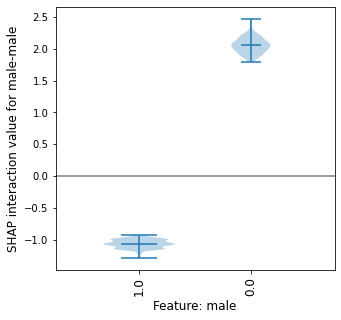

In [34]:
plot_violin_shap_interaction(X, shap_interaction, "male", "male");

We can also see the range of the SHAP interaction value between the features male-Pclass (divided by the male categories).

This shows that for females the SHAP interaction value between male-Pclass ranges from -0.6 to 0.9, and for males it has a smaller range (-0.6 to 0.3). Since this is in addition to the main effect (for which all females had a strong likelihood to survive), for some females their likelihood for surviving is further increased, whereas for others their likelihood for surviving is reduced.

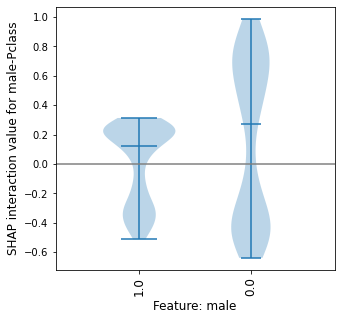

In [35]:
plot_violin_shap_interaction(X, shap_interaction, "male", "Pclass");

What this chart does not provide is an indication of the relationship of the Pclass values on the spread of values for each category.

This can be provided using a shap dependency plot - we will use the same data and represent these two violin plots as shap dependency plots.


## Detailed SHAP interactions using dependence plots
### Male - male interaction: SHAP main effect of male

We can see from the violin plot that the main effect (male-male) is quite different depending on whether the instance is male (a negative SHAP main effect value) or female (a positive SHAP main effect value).

This means that the feature will contribute a strong likelihood of survival if the instance is female, and a mid-strong likelihood of not surviving if the instance is male.

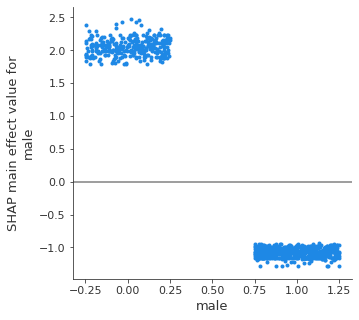

In [36]:
feature_name = "male"

fig = plt.figure()
ax = fig.add_subplot()
shap.dependence_plot(
    (feature_name, feature_name),
    shap_interaction, X,
    display_features=X,
    x_jitter=0.5,
    ax=ax,
    show=False)

# Add line at Shap = 0
n_violins = X[feature_name].nunique()
ax.plot([-1, n_violins + 1], [0,0],c='0.5') 

fig.set_figheight(5)
fig.set_figwidth(5)

plt.show()

Show male-Pclass SHAP interaction.

Note: The SHAP interaction for two features (e.g. male-Pclass) is splt between male-Pclass and Pclass-male. The total SHAP interaction is therefore 2* the individual interactions. We could multiply the interation by 2 to get the full SHAP interaction. Here we will plot both permutations and acknowledge that it's the sum of the pair (LHS shows columns as male and colour as Pclass. RHS shows columns as Pclass and colour as male). Each graph contains the exact same data points, and it is possible to match up the identical block of data points across the graphs.

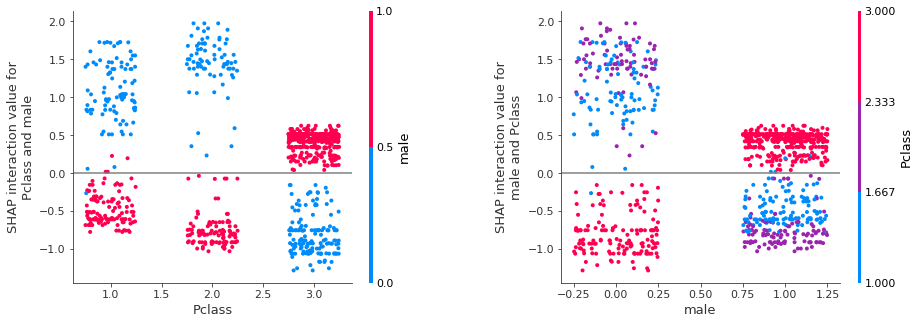

In [37]:
f1 = "Pclass"
f2 = "male"

fig = plt.figure()
ax = fig.add_subplot(121)
shap.dependence_plot(
    (f1, f2),
    shap_interaction, X,
    display_features=X,
    x_jitter=0.5,
    ax=ax,
    show=False)

# Add line at Shap = 0
n_violins = X[f1].nunique()
ax.plot([-1, n_violins + 1], [0,0],c='0.5') 

ax1 = fig.add_subplot(122)
shap.dependence_plot(
    (f2, f1),
    shap_interaction, X,
    display_features=X,
    x_jitter=0.5,
    ax=ax1,
    show=False)

# Add line at Shap = 0
n_violins = X[f2].nunique()
ax1.plot([-1, n_violins + 1], [0,0],c='0.5') 

fig.set_figheight(5)
fig.set_figwidth(15)
fig.subplots_adjust(wspace=.4)

plt.show()

## Grid of SHAP dependence plots

We will now show all of the SHAP interaction values in a grid of plots.

Each row and column represents a feature.

The diagonal graphs show the SHAP main effect for each feature. The SHAP interactions between features are off the diagonal, these are split symetrically (eg. age-male == male-age).

The SHAP main effect for feature male is shown in the top left (position [1, 1]). As already discussed, this shows that when the feature value is female, this has a strong contribution to the models prediction that the passenger will survive. And when this feature value is male there is a mid-strong contribution that the passenger will not survive.

The plot in position [2,2] shows the SHAP main effect for class. This shows that first class contributes a strong likelihood to survive, second class does not have much contribution, and third class contributes a strong likelihood not to survive.

But on top of these main effects we can see the contributon from the interation of these features. This is shown in positions [1, 2] and [2, 1]. The SHAP interaction between male and Pclass, and Pclass and male.

Graph in grid position [1, 2] shows the SHAP interaction between male and Pclass, the data has been split into columns by the value of the gender feature (female on left, male on right), and the colour represents the class feature (first class = blue, second class = purple, third class = red). The value represents the contribution to the likelihood of this passenger surviving due to this combination of values - this is in addition to the main effect that we saw in the top left.

It can be seen that passengers in first or second class further increase the likelihood of survival for females, and not surviving for males, as the SHAP interation value is in the same sign to the SHAP main effect: A female passenger in first or second class will increase the likelihood of survival from the models prediction, and so will further help your survival in addition to the fact that you are female (as we saw in the SHAP main effect); similarly a male passenger in first or second class will increase the likelihood of not surviving, and so will further contribute to the likelihood that you will not survive, in addition to the fact that you are male (as we saw in the SHAP main effect).
However the converse is true for passengers in third class, as the SHAP interation value is in the opposite sign to the SHAP main effect. A female passenger in third class will have a negative contribution to the survival (but remember that the main effect for female is a strong likelihood to survive), and if you are male in third class this combination will have a positive contribution to your survival (but remember that the main effect for female is a mid-strong likelihood to not survive).

The grid of dependency graphs are a mirror image across the diagonal. Meaning that the same data is shown in position [1,2] as in [2,1] just with the feature being displayed in the column or by colour is switched over.

Looking at the graph in the first column on the second row this shows the identical SHAP interation values for the features male - PClass, as we have just discussed above. Now the columns are per class (first, second, third) and the colour is by gender (male, female).
Here we see that for first and second class females contributes that there is a mid likelihood to not survive, whereas if male then contributes a positive likelihood to survive. But that this is opposite for third class, where is it the females (red) with a positive likelihood to survive.

This is also on top of the main effect from Pclass.

Resources used to make the grid of dependence plots: https://stackoverflow.com/questions/58510005/python-shap-package-how-to-plot-a-grid-of-dependence-plots \
(for future reference, not used here: https://gist.github.com/eddjberry/3c1818a780d3cb17390744d6e215ba4d)

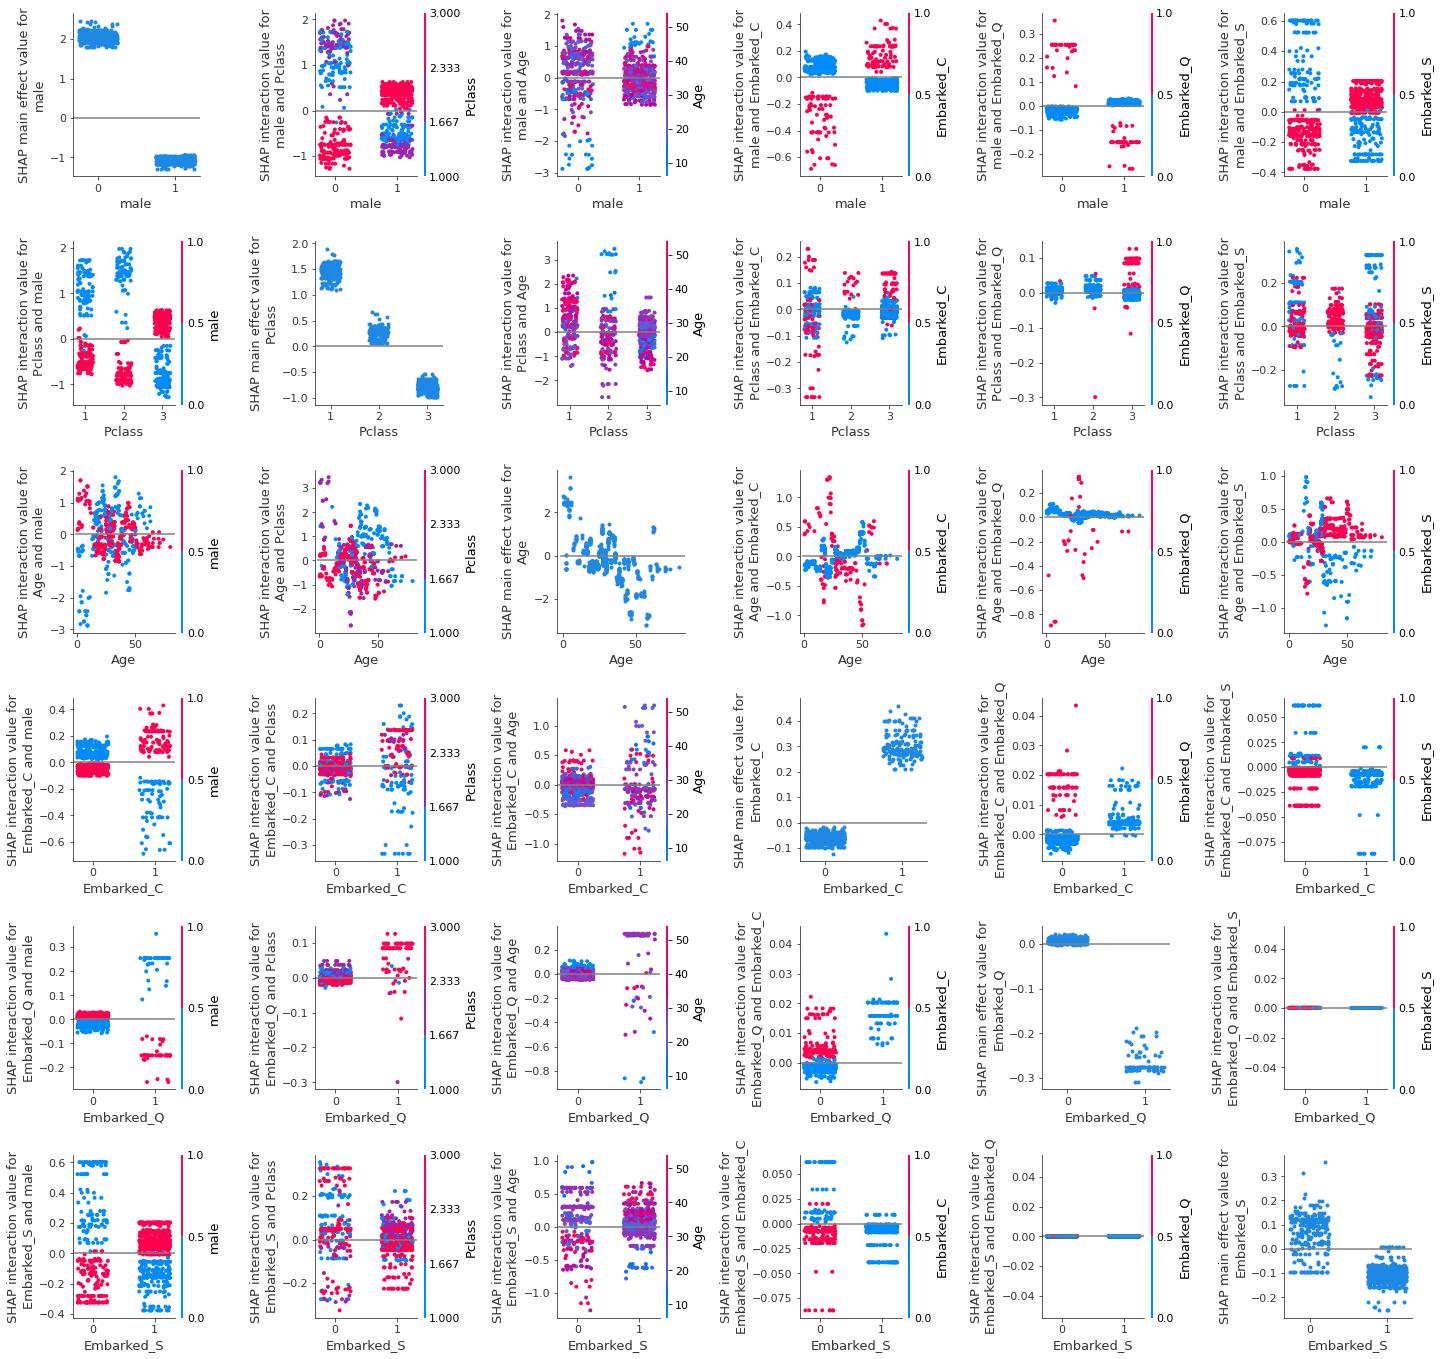

In [38]:
# Get feature names
features = X.columns

# Set up the matrix of subplots
fig, axes = plt.subplots(
    nrows=len(features), 
    ncols=len(features))
axes = axes.ravel()

# Plot each SHAP independence (and main effect on diagonal)
count = 0
for f1 in features:
    for f2 in features:
        
        # Add more jitter the fewer categories the feature has
        n_categories = X[f1].nunique()
        x_jitter = max(0, 0.7 - (n_categories * 0.1))
            
        # Plot data
        shap.dependence_plot(
            (f1, f2), shap_interaction, X, x_jitter=x_jitter, 
            display_features=X, show=False, ax=axes[count])
        
        # Add line at Shap = 0
        n_classes = X[f1].nunique()
        axes[count].plot([-1, n_classes + 1], [0,0],c='0.5')   
        count += 1

# Visual properties of figure
dimension = 4 * n_features
fig.set_figheight(dimension)
fig.set_figwidth(dimension)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.4, wspace=0.9)
plt.show()